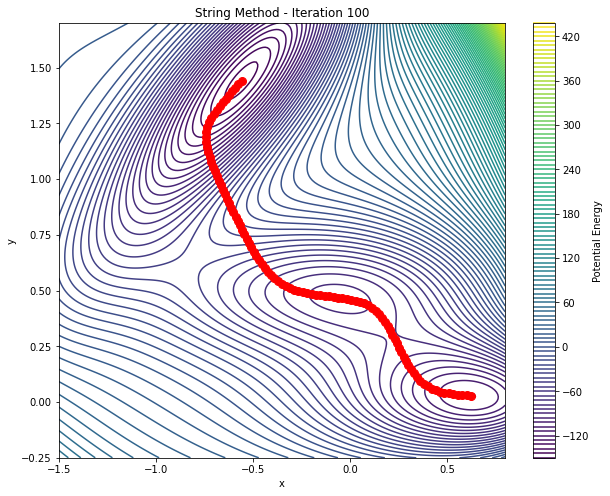

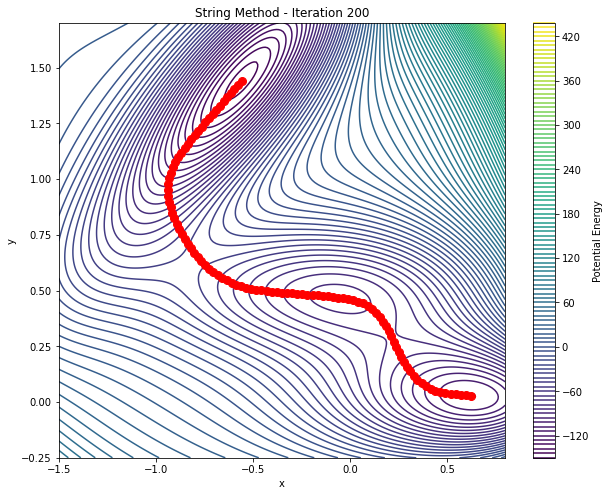

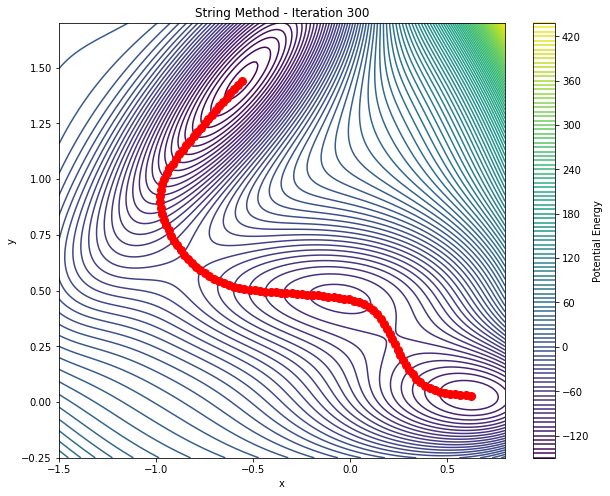

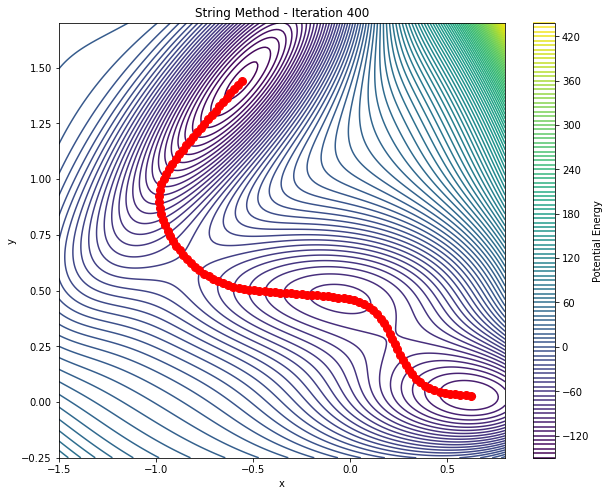

Converged after 414 iterations


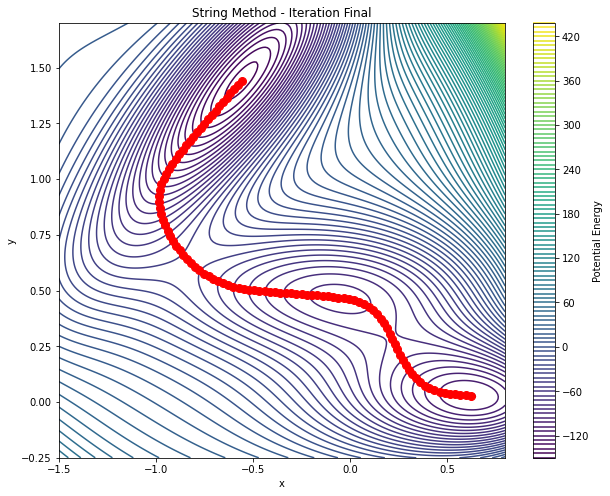

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def muller_brown_potential(x, y):
    A = [-200, -100, -170, 15]
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1]
    y0 = [0, 0.5, 1.5, 1]
    
    V = 0
    for i in range(4):
        V += A[i] * np.exp(a[i] * (x - x0[i])**2 + b[i] * (x - x0[i]) * (y - y0[i]) + c[i] * (y - y0[i])**2)
    return V

def muller_brown_force(string):
    A = [-200, -100, -170, 15]
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1]
    y0 = [0, 0.5, 1.5, 1]

    Fx = np.zeros(len(string))
    Fy = np.zeros(len(string))
    
    for i in range(4):
        dx = string[:, 0] - x0[i]
        dy = string[:, 1] - y0[i]
        exp_term = np.exp(a[i] * dx**2 + b[i] * dx * dy + c[i] * dy**2)
        
        Fx -= A[i] * (2 * a[i] * dx + b[i] * dy) * exp_term
        Fy -= A[i] * (b[i] * dx + 2 * c[i] * dy) * exp_term

    forces = np.column_stack((Fx, Fy))
    return forces

def reparametrize_string(string):
    cumulative_dist = np.concatenate(([0], np.cumsum(np.linalg.norm(np.diff(string, axis=0), axis=1))))
    total_dist = cumulative_dist[-1]
    new_cumulative_dist = np.linspace(0, total_dist, len(string))
    
    interpolator = interp1d(cumulative_dist, string, axis=0, kind='linear')
    new_string = interpolator(new_cumulative_dist)
    
    return new_string

def string_method(initial_string, max_iterations=1000, tolerance=1e-5, dt=0.00005):
    string = initial_string.copy()
    
    for iteration in range(max_iterations):
        # Calculate forces
        mb_force = muller_brown_force(string)
        total_force = mb_force
        
        string_new = string.copy()
        string_new += dt * total_force
        
        # Reparametrize the string (excluding end points)
        string_new[1:-1] = reparametrize_string(string_new)[1:-1]
        
        # Check for convergence
        if np.max(np.linalg.norm(string_new[1:-1] - string[1:-1], axis=1)) < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
        
        string = string_new
        
        # Visualize every 100 iterations
        if (iteration + 1) % 100 == 0:
            visualize_string(string, iteration + 1)
    
    return string

def visualize_string(string, iteration):
    plt.figure(figsize=(10, 8))
    
    # Plot potential energy surface
    x = np.linspace(-1.5, 0.8, 200)
    y = np.linspace(-0.25, 1.7, 200)
    X, Y = np.meshgrid(x, y)
    Z = muller_brown_potential(X, Y)
    plt.contour(X, Y, Z, levels=100, cmap='viridis')
    
    # Plot string
    plt.plot(string[:, 0], string[:, 1], 'ro-', linewidth=2, markersize=8)
    
    plt.title(f"String Method - Iteration {iteration}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label="Potential Energy")
    plt.show()

# Initialize and run the string method
x_lerp = np.linspace(-0.558,0.623, 100)
y_lerp = np.linspace(1.441, 0.028, 100)

initial_string = np.column_stack((x_lerp, y_lerp))


final_string_true = string_method(initial_string)
visualize_string(final_string_true, "Final")


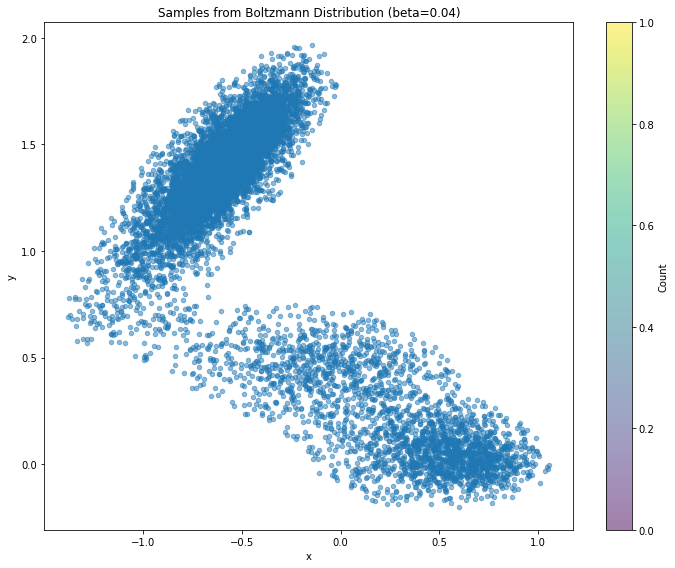

In [33]:
def generate_samples(n_samples, beta, step_size=0.5):
    samples = []
    x, y = np.random.uniform(-1.5, 1.2), np.random.uniform(-0.2, 2)
    current_V = muller_brown_potential(x, y)
    
    for _ in range(n_samples):
        # Propose a new state
        new_x = x + np.random.normal(0, step_size)
        new_y = y + np.random.normal(0, step_size)
        
        new_V =  muller_brown_potential(new_x, new_y)
        
        # Metropolis acceptance criterion
        if new_V < current_V or (np.random.random() < np.exp(-beta * (new_V - current_V))) & (new_V < -30) :
            x, y = new_x, new_y
            current_V = new_V
        
        samples.append((x, y))
    
    return samples[10000:]

# Example usage:
beta = 0.04  # Inverse temperature (increased for better exploration)
n_samples = 1010000

samples = generate_samples(n_samples, beta)

# Extract x and y coordinates for plotting
x_samples, y_samples = zip(*samples[::100])

# Create the plot
plt.figure(figsize=(10, 8))
#lt.hexbin(x_samples, y_samples, gridsize=50, cmap='viridis')
plt.scatter(x_samples, y_samples, s=20, alpha = 0.5)
plt.colorbar(label='Count')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Samples from Boltzmann Distribution (beta={beta})')
plt.tight_layout()

dataset = np.column_stack((x_samples, y_samples))

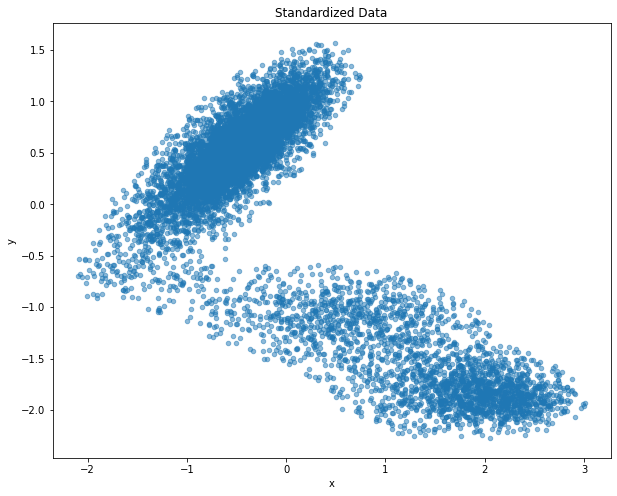

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

def standardize(dataset):
  """Standardizes a dataset by subtracting the mean and dividing by the standard deviation.

  Args:
    dataset: A NumPy array representing the dataset.

  Returns:
    A NumPy array representing the standardized dataset.
  """

  mean = np.mean(dataset, axis=0)
  std = np.std(dataset, axis=0)
  return mean, std

mean, std = standardize(dataset)

standardized_data = (dataset - mean) / std

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(standardized_data[:, 0], standardized_data[:, 1], s=20, alpha = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Standardized Data')
plt.show()

In [62]:
# Loading model
import torch
import torch.nn as nn
import torch.optim as optim
from utils import p_sample, p_sample_loop, q_sample
import matplotlib.pyplot as plt
from utils import EMA, noise_estimation_loss
import numpy as np
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        
        self.n_steps = n_steps
        self.betas = self.make_beta_schedule(start=1e-5, end=1e-2)
        self.alphas = 1 - self.betas
        self.alphas_prod = torch.cumprod(self.alphas, 0)
        self.alphas_prod_p = torch.cat([torch.tensor([1]).float(), self.alphas_prod[:-1]], 0)
        self.alphas_bar_sqrt = torch.sqrt(self.alphas_prod)
        self.one_minus_alphas_bar_log = torch.log(1 - self.alphas_prod)
        self.one_minus_alphas_bar_sqrt = torch.sqrt(1 - self.alphas_prod)

        
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
        
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)
    
    def make_beta_schedule(self, start=1e-5, end=1e-2):
        betas = torch.linspace(-6, 6, self.n_steps)
        betas = torch.sigmoid(betas) * (end - start) + start
        return betas
        
    def extract(self, input, t, x):
        shape = x.shape
        out = torch.gather(input, 0, t.to(input.device))
        reshape = [t.shape[0]] + [1] * (len(shape) - 1)
        return out.reshape(*reshape)

model = ConditionalModel(n_steps=100)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [63]:
dataset = torch.tensor(dataset).float()
ema = EMA(0.9)
ema.register(model)

batch_size = 512  

for t in range(1000):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        loss = noise_estimation_loss(model, batch_x)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        ema.update(model)
        batch_x = batch_x.cpu()

<ipython-input-64-4001684fed24>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model_0.04_Ereg.pth')


Converged after 1478 iterations


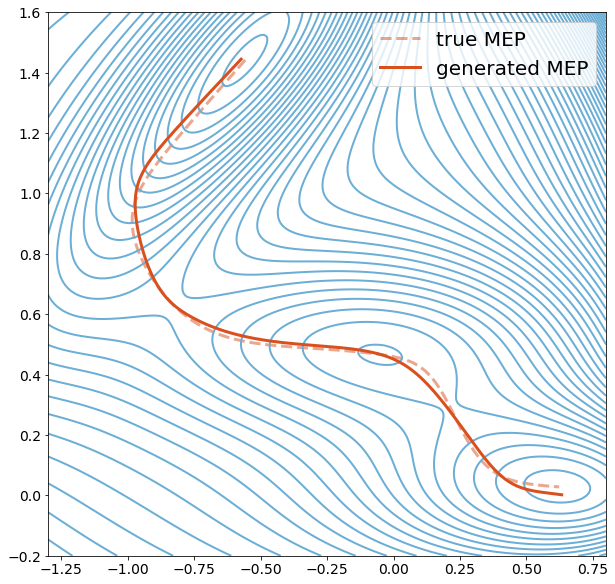

In [64]:
from stringmethod import StringMethod

n_steps = 100
model = ConditionalModel(n_steps)
state_dict = torch.load('model_0.04_Ereg.pth')
model.load_state_dict(state_dict)

def neural_ff(model, string, t):
    string_tensor = torch.tensor(string, dtype=torch.float32)
    t_tensor = torch.tensor([t], dtype=torch.long)
    
    with torch.no_grad():
        eps_theta = model(string_tensor, t_tensor)
    
    nn_force = -eps_theta / model.extract(model.one_minus_alphas_bar_sqrt, t_tensor, string_tensor)
    return nn_force.numpy()

def force_function(string):
    return neural_ff(model, string, noise_lvl)

def interpolate_states(state1, state2, num_steps):
    alpha = np.linspace(0, 1, num_steps)
    return np.array([(1-a) * state1 + a * state2 for a in alpha])


noise_lvl = 25

endpoints = np.array([[-0, 1],[2, -2]] )


initial_string = interpolate_states(endpoints[0], endpoints[1], num_steps=300)
string_method = StringMethod(initial_string, force_function, max_iterations=5000, dt=0.0005)
final_string = string_method.equilibrate()


plt.figure(figsize=(10, 10))
orng = "#D9501E"

final_string_transformed_x = std[0]*final_string[:, 0]+mean[0]
final_string_transformed_y = std[1]*final_string[:, 1]+mean[1]
final_string_transformed = np.column_stack([final_string_transformed_x, final_string_transformed_y])
plt.plot(final_string_true[:,0], final_string_true[:,1], color = orng, alpha = 0.5, linestyle = '--', linewidth = 3, label = 'true MEP')
#plt.scatter(final_string_transformed_x, final_string_transformed_y, color = orng, s = 40, alpha = 1, label = 'generated MEP',zorder = 5)
plt.plot(final_string_transformed_x, final_string_transformed_y, color = orng, alpha = 1, linewidth = 3, label = 'generated MEP',zorder = 5)

plt.legend(fontsize = 20)
x = np.linspace(-1.3, 0.8, 200)
y = np.linspace(-0.2, 1.6, 200)
X, Y = np.meshgrid(x, y)
Z = muller_brown_potential(X, Y)
plt.contour(X, Y, Z, levels=80, colors='#6baed6', linewidths=2.0, linestyles='solid')
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
#plt.savefig('example_string', dpi = 1000)
plt.show()

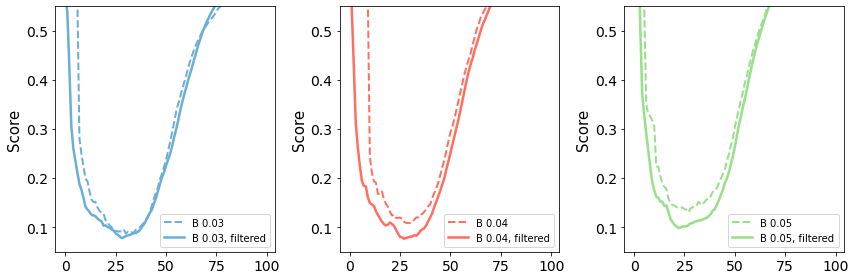

In [97]:
#import numpy as np
#import matplotlib.pyplot as plt
#from scipy.ndimage import uniform_filter1d

#colors = ['#6baed6', '#ff6f61', '#98df8a']
    
#fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
# Iterate over beta values and plot each curve in its respective subplot
#for idx, beta in enumerate([0.03, 0.04, 0.05]):
#    scores = np.loadtxt(f'string_accuracy_{beta}_10rep.txt')
#    scores_filtered = np.loadtxt(f'string_accuracy_{beta}_filtered_10rep.txt')
    

#    scores_smoothed = uniform_filter1d(scores, size=5)
#    scores_filtered_smoothed = uniform_filter1d(scores_filtered, size=5)
    

#    color = colors[idx]
    

#    axs[idx].plot(scores_smoothed, color=color, linestyle='--', linewidth=2, label=f'B {beta}')
#    axs[idx].plot(scores_filtered_smoothed, color=color, linewidth=2.5, label=f'B {beta}, filtered')
    #axs[idx].scatter(range(len(scores_filtered_smoothed)), scores_filtered_smoothed, color=color, s=20, alpha=0.6)
    

#    axs[idx].set_ylabel('Score', fontsize = 15)
#    axs[idx].legend(fontsize = 10)
#    axs[idx].set_ylim(0.05, 0.55)
#    axs[idx].tick_params(axis='both', labelsize=14)
    #axs[idx].grid()




#plt.tight_layout()
#plt.savefig('strings_acc', dpi = 1000)

#plt.show()